In [ ]:
import pandas as pd

In [ ]:
import random
import numpy as np

# set seed for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)

In [ ]:
# Target id
target_id = "CHEMBL262"

In [ ]:
from loader.load_chembl import parse_activities
# Load the data
target_raw = parse_activities(target_id=target_id)

In [ ]:
target_raw.shape

In [ ]:
from loader.clean_chembl import clean_data
# Clean the data
target_clean = clean_data(target_id=target_id, rewrite=False)

In [ ]:
target_clean.shape

In [37]:
import numpy as np

y10 = target_clean['standard_value'] * 1e-9 # to moles
y10 = -np.log(y10)
y10.dropna(inplace=True)

D:\python_projects\alzheimer-generative-design\venv\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [38]:
ids = y10.index

In [ ]:
from predictor.descriptor_computer import get_desc_dataset

rdkit_desc = get_desc_dataset(target_id, "rdkit")
rdkit_desc.shape

In [39]:
from predictor.processing import remove_collinear_features

x_rdkit_desc = rdkit_desc.drop(columns=["smiles", "standard_value"])
x_rdkit_desc = x_rdkit_desc.loc[ids, :]
x_rdkit_desc.dropna(axis=1, how="any", inplace=True)
x_rdkit_desc = x_rdkit_desc.select_dtypes(include=['number'])
x_rdkit_desc = x_rdkit_desc.loc[:, x_rdkit_desc.std() != 0]
x_rdkit_filtered = remove_collinear_features(x_rdkit_desc, threshold=0.7)

In [ ]:
from predictor.descriptor_computer import get_desc_dataset

mordred_desc = get_desc_dataset(target_id, "mordred")
mordred_desc.shape

In [40]:
x_mordred_desc = mordred_desc.drop(columns=["smiles", "standard_value"])
x_mordred_desc = x_mordred_desc.loc[ids, :]
x_mordred_desc.dropna(axis=1, how="any", inplace=True)
x_mordred_desc = x_mordred_desc.select_dtypes(include=['number'])
x_mordred_desc = x_mordred_desc.loc[:, x_mordred_desc.std() != 0]
x_mordred_filtered = remove_collinear_features(x_mordred_desc, threshold=0.8)

In [ ]:
from predictor.fingerprint_computer import get_fp_dataset
from rdkit.Chem import rdFingerprintGenerator

fp_gen = rdFingerprintGenerator.GetMorganGenerator(radius=2,fpSize=2048)
morgan_desc = get_fp_dataset(target_id, "morgan", fp_gen)
morgan_desc.head()

In [41]:
x_morgan_desc = morgan_desc.drop(columns=["smiles", "standard_value"])
x_morgan_desc = x_morgan_desc.loc[ids, :]

In [18]:
from sklearn.model_selection import KFold

n_splits = 5
cv = KFold(n_splits=n_splits, shuffle=True, random_state=SEED)
scoring = ['r2', 'neg_mean_absolute_error', 'neg_root_mean_squared_error']
results_path = 'results.csv'

In [43]:
from sklearn.decomposition import PCA
from sklearn.linear_model import Lasso, SGDRegressor
from sklearn.preprocessing import StandardScaler, PowerTransformer, MinMaxScaler, RobustScaler
from predictor.pipeline import run_pipeline
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.feature_selection import SelectKBest, f_regression, VarianceThreshold
# import xgboost
from xgboost import XGBRegressor
from catboost import CatBoostRegressor

# import xgboost
# import catboost
# import light

# baseline: RFRegressor
pipeline = run_pipeline(
    X=x_rdkit_desc,
    y=y10.squeeze(),
    cv=cv,
    model=RandomForestRegressor(
        # depth=4,
        # iterations=100,
        # l2_leaf_reg=3,
        # learning_rate=0.1,
        random_state=SEED, 
        # verbose=0
    ),
    # scaler=StandardScaler(),
    # selector=SelectKBest(f_regression, k=50),
    # dim_reducer=PCA(n_components=100),
    scoring=scoring,
    results_path=results_path,
)


KeyboardInterrupt



In [ ]:
# Optimise params
from sklearn.model_selection import GridSearchCV
from catboost import CatBoostRegressor
from sklearn.pipeline import Pipeline
from predictor.pipeline import get_preprocessing_pipeline

def tune_model_params(X, y, cv, selector=None, scaler=None, dim_reducer=None):
    preprocessing = get_preprocessing_pipeline(
        selector=selector,
        scaler=scaler,
        dim_reducer=dim_reducer
    )

    full_pipeline = Pipeline([
        ('preprocessing', preprocessing),
        ('model', CatBoostRegressor(verbose=0, random_state=42))
    ])

    param_grid = {
        'model__depth': [4, 6, 8],
        'model__learning_rate': [0.01, 0.05, 0.1],
        'model__l2_leaf_reg': [1, 3, 5],
        'model__iterations': [500]
    }

    grid_search = GridSearchCV(
        estimator=full_pipeline,
        param_grid=param_grid,
        cv=cv,
        scoring='r2',
        n_jobs=-1
    )

    grid_search.fit(X, y)
    print("Лучшие параметры:", grid_search.best_params_)
    print("R2 score (CV):", grid_search.best_score_)

    return grid_search.best_estimator_

In [ ]:

from predictor.pipeline import get_preprocessing_pipeline
# 1. Подбор лучших параметров
best_model_pipeline = tune_model_params(
    X=x_rdkit_desc,
    y=y10.squeeze(),
    cv=cv,
    scaler=StandardScaler()  # Или другие preprocessing шаги
)

# 2. Извлеки готовую модель
best_model = best_model_pipeline.named_steps['model']

# 3. Запусти эксперимент с лучшей моделью
final_pipeline = run_pipeline(
    X=x_rdkit_desc,
    y=y10.squeeze(),
    cv=cv,
    model=best_model,
    scaler=StandardScaler(),  # те же preprocessing шаги
    scoring=scoring,
    results_path=results_path
)

D:\python_projects\alzheimer-generative-design\venv\lib\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


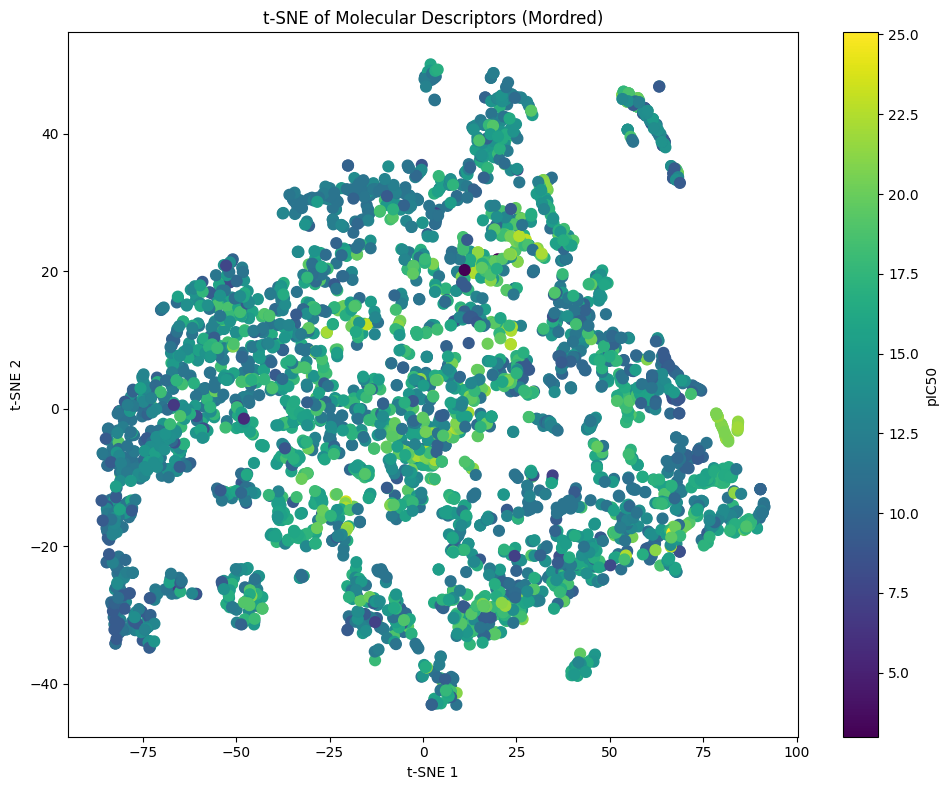

In [46]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt


X = x_mordred_desc

tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
X_embedded = tsne.fit_transform(X)

# Plot with continuous color scale
plt.figure(figsize=(10, 8))
sc = plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=y10, cmap='viridis', s=60)
plt.colorbar(sc, label='pIC50')
plt.title('t-SNE of Molecular Descriptors (Mordred)')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.tight_layout()
plt.show()